# Conjugate gradients

Conjugate Gradients (CG) is a widespread optimisation method that is applicable to continuous optimisation problems where the first-order derivatives of the objective are available. These notes are roughly based off of Jonathan R. Shewchuk's{cite}`shewchuk` notes on CG.

## Motivating Conjugate Gradients

We motivate CG by first discussing the Steepest Descent and Conjugate Direction methods, in the context of minimising quadratic functions of the form

$$ \text{minimise}~~~F(x) = \frac{1}{2} x^\top A x - b^\top x,$$

where $x, b \in \mathbb{R}^D$, $A$ is a symmmetric positive semi-definite matrix. With minor modifications, CG is also applicable to non-quadratic problems.

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

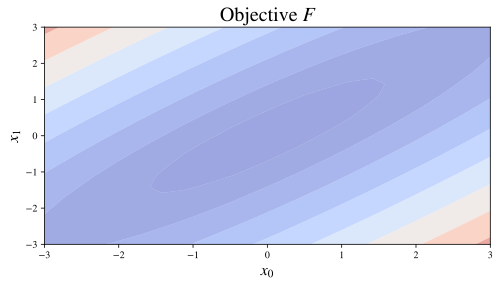

In [5]:
# Define objective function
def F(A, b, x):
    
    F_ = 0.5 * np.einsum('...i, ij, ...j -> ...', x, A, x)
    F_ = F_ - np.dot(x, b)
    
    return F_


def plot_F(A, b, show):
    
    num_points = 20
    
    x1_lin = np.linspace(-3, 3, num_points)
    x2_lin = np.linspace(-3, 3, num_points)
    
    x1_grid, x2_grid = np.meshgrid(x1_lin, x2_lin)
    x_grid = np.stack([x1_grid, x2_grid], axis=-1)
    
    F_ = F(A, b, x_grid)
    
    plt.figure(figsize=(8, 4))
    
    levels = np.linspace(0, 4.5, 10) ** 2
    plt.contourf(x1_grid, x2_grid, F_, cmap='coolwarm', alpha=0.5, levels=levels)
    
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    
    plt.xlabel('$x_0$', fontsize=16)
    plt.ylabel('$x_1$', fontsize=16)
    
    if show: plt.show()

# A and b for defining the quadratic form
A = np.array([[1.0, -0.9],
              [-0.9, 1.0]])

b = np.array([0., 0.])

plot_F(A, b, show=False)

plt.title('Objective $F$', fontsize=20)
plt.show()

### Steepest Descent

We can try solving the quadratic problem above iteratively, by starting from an initial guess $x = x_0$ and repeatedly taking steps towards the direction of steepest decrease of $F$

$$\begin{align}
x_{n + 1} = x_n + \alpha_n g_n, \text{ where } g_n = \nabla F(x_n).
\end{align}$$

where $\alpha_n$ is an appropriately chosen step size. For quadratic problems, we can choose the $\alpha_n$ which minimises

$$\begin{align}
\DeclareMathOperator*{\argmin}{arg\,min}
\alpha_n = \argmin_\alpha F(x_n + \alpha g_n) = - \frac{g_n^\top g_n}{g_n^\top A g_n},
\end{align}$$

in closed form - see derivation below.

<details class="proof">
<summary>Proof: Optimal single-step size for steepest descent</summary>

The step size $\alpha_n$ that minimises the objective in the direction of $g_n$ is
    
$$\begin{align}
\DeclareMathOperator*{\argmin}{arg\,min}
\alpha_n = \argmin_\alpha F(x_n + \alpha g_n)
\end{align}$$
    
and satisfies
    
$$\begin{align}
\frac{d}{d\alpha_n} F(x_n + \alpha_n g_n) = 0 \implies A(x_n + \alpha_n g_n) - b = 0.
\end{align}$$
    
Taking the inner product with $g_n$ and rearranging we arrive at
    
$$\begin{align}
\alpha_n = - \frac{g_n^\top g_n}{g_n^\top A g_n}.
\end{align}$$
    
</details>
<br>

The issue with this algorithm, as illustrated by the following example, is that when there is a large difference between the largest and smallest eigenvalues of $A$, the algorithm can jump around instead of moving towards the minimum.

In [6]:
def quadratic_steepest_descent(A, b, x0, num_steps):
    
    x = x0
    x_hist = [x0]
    F_hist = [F(A, b, x)]
    
    for i in range(num_steps):
        
        g = np.dot(A, x) - b
        
        gT_g = np.dot(g, g)
        gT_A_g = np.einsum('i, ij, j -> ', g, A, g)
        
        a = - gT_g / gT_A_g
        
        x = x + a * g
        
        x_hist.append(x)
        F_hist.append(F(A, b, x))
        
    return np.array(x_hist), np.array(F_hist)

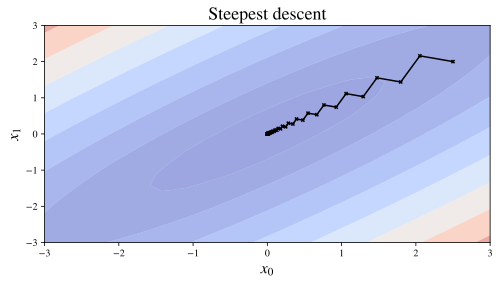

In [9]:
# A and b for defining the quadratic form
A = np.array([[1.0, -0.9],
              [-0.9, 1.0]])

b = np.array([0., 0.])

# Initial guess
x0 = np.array([2.5, 2.0])

# Number of steps of steepest descent
num_steps = 50

# Execute steepest descent algorithm
x_hist, F_hist = quadratic_steepest_descent(A, b, x0=x0, num_steps=num_steps)

# Plot the loss function
plot_F(A, b, show=False)

# Plot path taken by steepest descent
plt.scatter(x_hist[:, 0], x_hist[:, 1], marker='x', color='k', s=10)
plt.plot(x_hist[:, 0], x_hist[:, 1], color='k')

plt.title('Steepest descent', fontsize=18)
plt.show()

### Conjugate directions

How can we fix this problem where the optimiser taking large steps in opposite directions? One idea would be to constrain the search directions to be orthogonal to each other. For example, we could pick the basis set of $x$, say $\{u_0, u_1, ..., u_D\}$ as the search directions and take steps in each direction by finding the step size $\alpha_n$ that minimises $F$ along the search direction.

In [10]:
def quadratic_orthogonal_descent(A, b, x0, num_steps):
    
    x = x0
    x_hist = [x0]
    F_hist = [F(A, b, x)]
    
    num_dim = A.shape[0]
    
    for i in range(num_steps):
        
        g = np.dot(A, x) - b
        
        u = np.zeros(num_dim)
        u[i % num_dim] = 1
        
        gT_u = np.dot(g, u)
        uT_A_u = np.einsum('i, ij, j -> ', u, A, u)
        
        a = - gT_u / uT_A_u
        
        x = x + a * u
        
        x_hist.append(x)
        F_hist.append(F(A, b, x))
        
    return np.array(x_hist), np.array(F_hist)

Perhaps this sounds like a good idea, but it isn't. As illustrated below, the optimisation process can still jump around a great deal, and converge to the minimum very slowly. This occurs because although the search directions are orthogonal to each other, the fact that the eigenvectors of $A$ are at an angle to the search directions prevent the algorithm from making large steps.

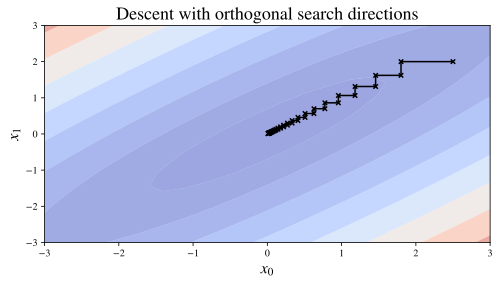

In [13]:
# A and b for defining the quadratic form
A = np.array([[1.0, -0.9],
              [-0.9, 1.0]])

b = np.array([0., 0.])

# Initial guess
x0 = np.array([2.5, 2.0])

# Number of steps of descent
num_steps = 50

# Execute descent with orthogonal search directions
x_hist, F_hist = quadratic_orthogonal_descent(A, b, x0=x0, num_steps=num_steps)

# Plot the loss function
plot_F(A, b, show=False)

# Plot path taken by orthogonal search directions
plt.scatter(x_hist[:, 0], x_hist[:, 1], marker='x', color='k', s=20)
plt.plot(x_hist[:, 0], x_hist[:, 1], color='k')

plt.title('Descent with orthogonal search directions', fontsize=18)
plt.show()

If the search directions were orthogonal and $A$ was a diagonal matrix, then the search would reach the optimum within $D$ steps - see the example below.

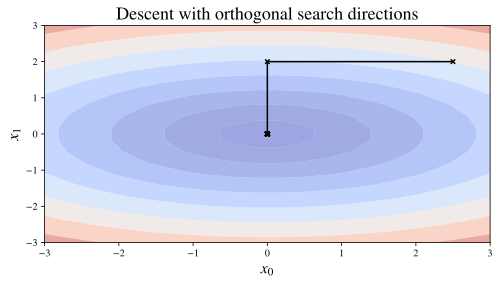

In [15]:
# A and b for defining the quadratic form
A = np.array([[1.0, 0.0],
              [0.0, 3.0]])

b = np.array([0., 0.])

# Initial guess
x0 = np.array([2.5, 2.0])

# Number of steps of steepest descent
num_steps = 50

# Execute descent with orthogonal search directions
x_hist_ortho, F_hist_ortho = quadratic_orthogonal_descent(A, b, x0=x0, num_steps=num_steps)

# Plot the loss function
plot_F(A, b, show=False)

# Plot path taken by orthogonal search directions
plt.scatter(x_hist_ortho[:, 0], x_hist_ortho[:, 1], marker='x', color='k', s=20)
plt.plot(x_hist_ortho[:, 0], x_hist_ortho[:, 1], color='k')

plt.title('Descent with orthogonal search directions', fontsize=18)
plt.show()

This points at the idea of choosing search directions $\{d_0, d_1, ..., d_{D - 1}\}$ which are orthogonal in the space spanned by the eigenvectors of $A$. Any such set of vectors must be $A$-orthogonal in the sense

$$\begin{align}
d_i A d_j = 0, \text{ if } i \neq j.
\end{align}$$

How can achieve $A$-orthogonality? Given any basis set, say $\{u_0, u_1, ..., u_{D - 1}\}$ we can prodce another basis that is $A$-orthogonal, by removing from each basis vector all components that are not $A$-orthogonal to any preceeding vectors

$$\begin{align}
v_i = u_i + \sum_{j = 1}^{i - 1} \beta_{ij} v_j.
\end{align}$$

where $v_0 = u_0$ and $\beta_{ij}$ are appropriately chosen constants such that $d_i A d_j = 0$ whenever $i \neq j$

$$\begin{align}
\beta_{ij} = - \frac{u_i^\top A v_j}{v_j^\top A v_j}.
\end{align}$$

<details class="proof">
<summary>Proof: Deriving the \(\beta_{ij}\) coefficients</summary>

Starting from the expression
    
$$\begin{align}
v_i = u_i + \sum_{j = 1}^{i - 1} \beta_{ij} v_j,
\end{align}$$
    
take the product with $v_j^\top A$ to obtain
    
$$\begin{align}
v_j^\top A v_i = v_j^\top A u_i + \sum_{k = 1}^{i - 1} \beta_{ik} v_j^\top A v_k.
\end{align}$$
    
Using the requirement that $v_j^\top A v_k = 0$ if $j \neq k$ and rearranging we arrive at
    
$$\begin{align}
\beta_{ij} = -\frac{u_i^\top A v_j}{v_j^\top A v_j}.
\end{align}$$
   
    
</details>
<br>

This is called a *conjugate Gram-Schmidt process*. Its disadvantage is that all previous search vectors must be kept in memory to generate a new search vector.

In [16]:
def quadratic_gram_schmidt(A, b, x0):
    
    x = x0
    x_hist = [x0]
    F_hist = [F(A, b, x)]
    
    num_dim = A.shape[0]
    
    # Create orthogonal u basis
    U = [u for u in np.eye(num_dim)]
    
    D = []
    
    # Execute descent
    for i in range(num_dim):
        
        # Gradient wrt x and search direction
        g = np.dot(A, x) - b
        
        d_i = U[i]
        for j in range(i):
            
            b_ij = - np.dot(U[i], np.dot(A, D[j]))
            b_ij = b_ij / np.dot(D[j], np.dot(A, D[j]))
            
            d_i = d_i + b_ij * D[j]
            
        D.append(d_i)
        
        gT_d = np.dot(g, d_i)
        dT_A_d = np.einsum('i, ij, j -> ', d_i, A, d_i)
        
        a = - gT_d / dT_A_d
        
        x = x + a * d_i
        
        x_hist.append(x)
        F_hist.append(F(A, b, x))
        
    return np.array(x_hist), np.array(F_hist)

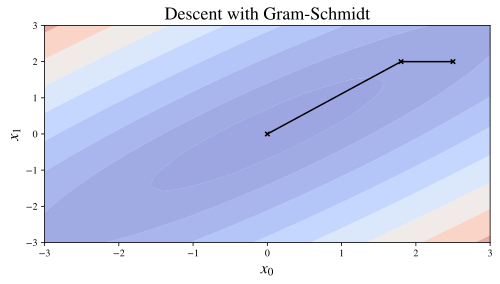

In [17]:
# A and b for defining the quadratic form
A = np.array([[1.0, -0.9],
              [-0.9, 1.0]])

b = np.array([0., 0.])

# Initial guess
x0 = np.array([2.5, 2.0])

# Number of steps of steepest descent
num_steps = 50

# Execute descent with Gram-Schmidt orthogonalised directions
x_hist_gram_schmidt, F_hist_gram_schmidt = quadratic_gram_schmidt(A, b, x0=x0)

# Plot the loss function
plot_F(A, b, show=False)

# Plot path taken using Gram-Schmidt orthogonalised directions
plt.scatter(x_hist_gram_schmidt[:, 0], x_hist_gram_schmidt[:, 1], marker='x', color='k', s=20)
plt.plot(x_hist_gram_schmidt[:, 0], x_hist_gram_schmidt[:, 1], color='k')

plt.title('Descent with Gram-Schmidt', fontsize=18)
plt.show()

For quadratic $F$, conjugate directions (with Gram-Schmidt) converges in $D$ steps, where $D$ is the dimensionality of the problem. However, Gram-Schmidt must keep track of all previous search directions and adjust the next search direction to be $A$-orthogonal to them, which incurs a memory as well as a computational cost. This brings us to the method Conjugate Gradients (CG), which fixes this issue by picking sensible search directions $d_0, d_1, ...$, leveraging the fact that $f$ is a quadratic form.

## Conjugate Gradients

Our choice of setting $u_0$ equal to the basis was an arbitrary decision to get the algorithm started, but is not at all sensible. For one, if we use this choice then the initial search direction $d_0$ does not at all depend on $A$ or $b$ at all - surely there must be a better initial condition. Consider instead setting

$$ u_n = -g_n = \nabla F(x_n) = -(Ax_n - b). $$

This seems more sensible, because it at least takes into account local information about $F$ by means of the gradient. However, it turns out that this decision brings more benefits than is immediately obvious. Under the choice $u_n = -g_n$, the Gram-Schmidt conjugation step becomes

$$d_{n + 1} = - g_{n + 1} + \sum_{k = 1}^n \beta_{nk} d_k,$$

while the transition rule still has the form

$$\begin{align}
x_{n + 1} &= x_n + \alpha_n d_n.
\end{align}$$

Because $\nabla F(x_n) = -(Ax_n - b)$, the gradient also evolves according to

$$\begin{align}
g_{n + 1} = g_n + \alpha_n A d_n.
\end{align}$$ 

It can be shown (see below) that all Gram-Schmidt coeffiecients appart from $\beta_{n, n - 1}$ vanish, giving the iterative step

$$\begin{align}
x_{n + 1} &= x_n + \alpha_n d_n, && \text{ where } \alpha_n = - \frac{d_n^\top g_n}{d_n^\top Ad_n},\\
g_{n + 1} &= g_n + \alpha_n A d_n, \\
d_{n + 1} &= - g_{n + 1} + \beta_n d_n, && \text{ where } \beta_n = \frac{g_{n + 1}^\top A d_n}{d_n^\top Ad_n}.
\end{align}$$

<details class="proof">
<summary>Proof: The Gram-Schmidt coefficients for Conjugate Gradients</summary>

Suppose we set $u_n = -g_n$, start from $x = x_0$ and evolve according to the transition rules
    
$$\begin{align}
x_{n + 1} &= x_n + \alpha_n d_n, \\
g_{n + 1} &= g_n + \alpha_n A d_n, && \text{ where } \alpha_n = - \frac{d_n^\top g_n}{d_n^\top Ad_n}, \\
d_{n + 1} &= - g_{n + 1} + \sum_{k = 1}^n \beta_{nk} d_k,
\end{align}$$
    
where the constants $\beta_{nk}$ are chosen so that the $d_n$ vectors are all $A$-orthogonal. Defining the spanning set
    
$$\begin{align}
\mathcal{D}_{n + 1} &= \text{span}~(d_0, d_1, d_2, ..., d_n),
\end{align}$$
    
we can see that minimising the objective by minimising the objective along each of the search directionsin turn, is equivalent to minimising the objective jointly over $x_0 + \mathcal{D}_{n + 1}$, because the vectors $\{d_0, d_1, d_2, ..., d_n\}$ are $A$-orthogonal. Therefore, the gradient $g_{n + 1}$ at $x = x_{n + 1}$ is othogonal (not $A$-orthogonal but $I$-orthogonal) to the spanning set $\mathcal{D}_{n + 1}$, because otherwise the position $x_{n + 1}$ would not be a minimiser of the objective within $x_0 + \mathcal{D}_{n + 1}$, which we can write as
    
$$\begin{align}
g_n \perp d_m \text{ for all } m < n.
\end{align}$$
    
In addition we observe that the span $\mathcal{D}_{n + 1}$ can be written as
    
$$\begin{align}
\mathcal{D}_{n + 1} &= \text{span}~(d_0, d_1, d_2, ..., d_n) \\
              &= \text{span}~(d_0, Ad_0, A^2 d_0, ..., A^{n - 1} d_n),
\end{align}$$
    
where at any given step of the algorithm, the set is augmented from $\mathcal{D}_n$ to $\mathcal{D}_n + A\mathcal{D}_{n + 1}$. Since $A\mathcal{D}_n \subseteq \mathcal{D}_{n + 1}$ we have
    
$$\begin{align}
g_{n + 1} \perp \mathcal{D}_n \implies g_{n + 1} \perp A\mathcal{D}_{n - 1},
\end{align}$$
    
so $d_m^\top A g_{n + 1} = 0$ for all $m < n$. Using this we see that all Gram-Schmidt coefficients must vanish except for $\beta_{nn}$. We therefore call this coeffient $\beta_n$ and compute its value as
    
$$\begin{align}
\beta_n = \frac{g_{n + 1}^\top A d_n}{d_n^\top Ad_n}.
\end{align}$$
    
**Intuition:** The vanishing of the Gramm-Schmidt coefficients relies on the fact that $g_{n + 1} \perp A\mathcal{D}_{n - 1}$, which follows from the facts that $g_{n + 1} \perp \mathcal{D}_n$ and that $\mathcal{D}_n$ is a Krylov space
    
$$\begin{align}
\mathcal{D}_n = \text{span}~(d_0, Ad_0, A^2 d_0, ..., A^{n - 1} d_{n-1}).
\end{align}$$
    
The fact that $\mathcal{D}_n$ is a Krylov space is a consequence of choosing $u_n = -g_n$. If instead we had picked $u_n$ to be one-hot vectors with a $1$ in the $n^{th}$ entry, then $\mathcal{D}_n$ would not be a Krylov space and the Gram-Schmidt coefficients would not in cancel in general.
    
</details>
<br>

Note how at each step we only have to compute a single Gram-Schmidt term $\beta_n A d_n$, and that we don't need to keep all previous search directions $d_0$ through to $d_{n - 1}$ in memory anymore.

In [18]:
def conjugate_gradients(A, b, x0):
    
    x = x0
    x_hist = [x0]
    F_hist = [F(A, b, x)]
    
    num_dim = A.shape[0]
            
    g = np.dot(A, x) - b
    d = - g
    
    # Execute descent
    for i in range(num_dim):
        
        alpha = - np.dot(d, g) / np.dot(d, np.dot(A, d))
        
        x = x + alpha * d
        x_hist.append(x)
        F_hist.append(F(A, b, x))
        
        g = g + alpha * np.dot(A, d)

        beta =  np.dot(g, np.dot(A, d)) / np.dot(d, np.dot(A, d))
        d = - g + beta * d
        
    return np.array(x_hist), np.array(F_hist)

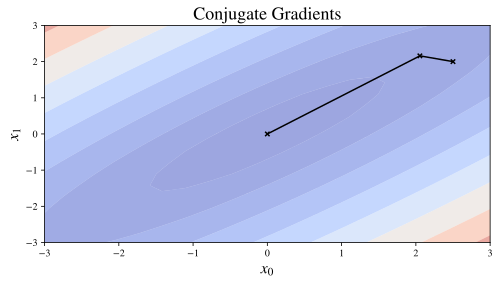

In [23]:
# A and b for defining the quadratic form
A = np.array([[1.0, -0.9],
              [-0.9, 1.0]])

b = np.array([0., 0.])

# Initial guess
x0 = np.array([2.5, 2.0])

# Number of steps of steepest descent
num_steps = 50

# Execute descent with Conjugate Gradients
x_hist_cg, F_hist_cg = conjugate_gradients(A, b, x0=x0)

# Plot the loss function
plot_F(A, b, show=False)

# Plot path taken by Conjugate Gradients
plt.scatter(x_hist_cg[:, 0], x_hist_cg[:, 1], marker='x', color='k', s=20)
plt.plot(x_hist_cg[:, 0], x_hist_cg[:, 1], color='k')

plt.title('Conjugate Gradients', fontsize=18)
plt.show()

We also apply each of these algorithms to a larger problem. We pick a random matrix $A$ (which will almost surely be rank $d$) and make it positive-definite by setting $A \leftarrow A A^\top$. We also pich the vector $b$ randomly. We optimise the quadratic objective using each method and compare their performance.

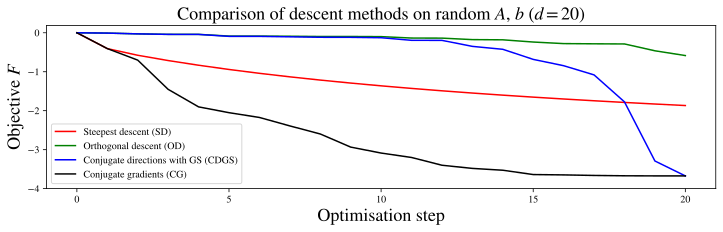

In [22]:
# Set random seed
np.random.seed(0)

# A and b for defining the quadratic form
A = np.random.normal(size=(20, 20))
A = np.dot(A, A.T)

b = np.random.normal(size=(20,))

# Initial guess
x0 = np.zeros(shape=(20,))

# Number of steps of steepest descent
num_steps = 20

# Execute descent with orthogonal search directions
_, F_hist_steep = quadratic_steepest_descent(A, b, x0=x0, num_steps=num_steps)
_, F_hist_ortho = quadratic_orthogonal_descent(A, b, x0=x0, num_steps=num_steps)
_, F_hist_gs = quadratic_gram_schmidt(A, b, x0=x0)
_, F_hist_cg = conjugate_gradients(A, b, x0=x0)


# Figure for objectives
plt.figure(figsize=(12, 3))

# Plot objective
plt.plot(F_hist_steep, color='r', label='Steepest descent (SD)')
plt.plot(F_hist_ortho, color='g', label='Orthogonal descent (OD)')
plt.plot(F_hist_gs, color='b', label='Conjugate directions with GS (CDGS)')
plt.plot(F_hist_cg, color='k', label='Conjugate gradients (CG)')

# Plotting options
plt.title('Comparison of descent methods on random $A$, $b$ ($d = 20$)', fontsize=18)
plt.xlabel('Optimisation step', fontsize=18)
plt.ylabel('Objective $F$', fontsize=18)
plt.xticks(np.arange(0, 21, 5))
plt.yticks(np.arange(0., -5, -1))
plt.legend()

plt.show()

Note that CDGS and CG produce the same solution. GS initially enjoys larger improvements because it moves closer to the direction of steepest descent. For the first steps, SD and CG have the same perfromance because they move along the same direction, but CG subsequently outperforms SD.

## Nonlinear Conjugate Gradients

We derived and applied CG to a quadratic objective, but ultimately we are interested in non-quadratic problems. Although quadratic objectives are of limited interest, one notable application of CG is for solving linear equations of the form $Ax = b$, where $A$ is a sparse matrix. In such cases, the computations involved in computing the conjugate directions can be sped up, improving the overall cost of the algorithm - compared to the $\mathcal{O}(D^3)$ cost of Gaussian elimination.

To apply CG to a non-quadratic $F$, we must modify it in three places. First, and most importantly, what does it mean for the search directions to be conjugate, when the problem is non-quadratic and thus has a varying Hessian? One interpretation is that if we are sufficiently close to a local minimum, the objective will be roughly quadratic, so we can approximate $F$ as a quadratic and apply CG. To achieve this, we could apply Gram-Schmidt to make each $d_n$ $A$-orthogonal to all previous search directions. But we don't want to give up the computational efficiency of the CG update rule either, so we will apply a rule that looks a lot like the CG update rule:

$$\begin{align}
d_{n + 1} &= - g_{n + 1} + \beta_n d_n, && \text{ where } \beta_n = \frac{g_{n + 1}^\top (g_{n + 1} - g_n)}{g_n^\top g_n}.
\end{align}$$

This is called the Polak-Ribiere (PR) update rule and reduces to the exact update rule we derived earlier whenever $F$ is quadratic - there exist variety of alternative such rules.{cite}`conjugatemethods` Alternative update rules may be equivalent when when the objective is quadratic, they are not equivalent when the objective is non-quadratic. The choice of update rule makes a difference in this case, however we will not focus on this here and work with PR from now on.

Second, we have to solve for $\alpha_n$ approximately. When $F$ was known and quadratic we obtained the optimal step size in closed form

$$ \alpha_n = - \frac{d_n^\top g_n}{d_n^\top Ad_n}, $$

however in most cases of interest this will not be possible, either because the function $F$ is not available to us, or because the solution simply does not exist in closed form even if the analytic form of $F$ was available. We therefore will have to approximately solve the optimisation problem

$$\begin{align}
\alpha_n = \argmin_{\alpha \geq 0} F(x_n + \alpha d_n).
\end{align}$$

This optimisation is called a line search problem because it amounts to searching for a minimiser along the line $x_n + \alpha d_n$. Lastly, in quadratic problems we updated the gradient according to

$$\begin{align}
g_{n + 1} = \nabla F(x_{n + 1}) = \nabla F(x_n) + \alpha_n A d_n = g_n + \alpha_n A d_n.
\end{align}$$

The change in the gradient was a linear transformation of the search direction. That's because $F$ was quadratic, so its gradient was affine in $x$. This is no longer true, so instead we re-compute the gradient at each step

$$\begin{align}
g_{n + 1} = \nabla F(x_{n + 1}).
\end{align}$$

In particular, we assume that the objective function $F$ returns both its value as well as the partial derivatives w.r.t. $x$ at the point being queried. Next we discuss solving the line search problem.

### Line search

For a quadratic objective $F$, we can obtain the minimiser $\alpha_n$

$$\begin{align}
\alpha_n = \argmin_{\alpha \geq 0} F(x_n + \alpha d_n)
\end{align}$$

in closed form. However, for more complicated objectives $\alpha_n$ will not be closed-form and must find an approximate solution to it. Line search algorithms attempt to solve this optimisation problem by searching along the line $x_n + \alpha d_n$ until a satisfactory solution is found. For convenience, we define the univariate function

$$\begin{align}
f(a) = F(x_n + \alpha d_n).
\end{align}$$

A candidate solution is deemed acceptable if it satisfies certain conditions. A widespread choice for these conditions are the strong Wolfe-Powell (WP) conditions:

$$\begin{align}
f(\alpha) \leq f(0) + c_1 \alpha f'(0) \label{wp1}, \\
|f'(\alpha)| \leq c_2 |f'(0)|          \label{wp2}.
\end{align}$$

where $c_1$ and $c_2$ are positive constants. The first condition says that the candidate minimiser should be better than the initial point $x_n$ by an amount at least as large as the fraction of the improvement expected by a linear approxmation to $F$. If this condition is not met, we can likely find a better point in the neighbourhood of $\alpha$. The second condition, says that the magnitude of the gradient of the objective $f'(\cdot)$ should not be greater than a fraction of the gradient at the initial point. If this condition is not met at $\alpha$, it is likely we can find a significantly better point in the neighbourhood of $\alpha$. If both conditions are satisfied, we deemm the solution good enough and accept the point as an approximate solution to the line search. Below is an implementation for a helper function checking for the WPCs.

In [12]:
def wolfe_powell(p0, p, c1, c2):
    """
    Takes points *p0* and *p* and constants *c1* and *c2* and determines
    whether *p1* satisfies the Wolfe-Powell conditions w.r.t. *p0*:
    
        f(p) <= f(p0) + c1 * (x1 - x0) *  f'(p0),
        |f'(p1)| <= c2 * |f'(p0)|.
        
    Parameters
    ----------
    
    p0 : dict
        Must contain keys 'x', 'f' and 'dfdx'.
        
    p1 : dict
        Must contain keys 'x', 'f' and 'dfdx'.
        
    c1 : float
        Must satisfy 0 < c1 <= c2 < 1.
        
    c2 : float
        Must satisfy 0 < c1 <= c2 < 1.
        
    Returns
    ----------
    
    wp : bool
        True if both WPCs are satisfied, else False
        
    wp1 : bool
        True if first WPC is satisfied, else False
        
    wp2 : tup
        Tuple of bools of length 3, each of which corresponding to
        
             f'(p1)  < - c2 * |f'(p0)|,
             f'(p1)  >   c2 * |f'(p0)|,
            |f'(p1)| <   c2 * |f'(p0)|.
    """
    
    # First WPC
    wp1 = p['f'] <= p0['f'] + c1 * (p['x'] - p0['x']) * p0['dfdx']
    
    # Second WPC, with each possibility in the inequality separate
    wp2 = [False, False, False]
    
    # Set each entry of the second WPC separately
    if p['dfdx'] < - c2 * np.abs(p0['dfdx']):
        wp2[0] = True
        
    elif p['dfdx'] > c2 * np.abs(p0['dfdx']):
        wp2[1] = True
        
    else:
        wp2[2] = True
    
    # If first and second WPCs hold, this is True, otherwise False
    wp = wp1 and wp2[2]
    
    return wp, wp1, wp2

If our fist guess passes the WPCs, then it is acceptable and the line search stops. If it is not accepted however, we must find a next candidate point. We can achieve this using the following algorithm.

<div class="lemma">
    
**Algorithm (Bisection line search)** Given a univariate $f(\cdot)$ with $f'(0) < 0$, constants $c_1, c_2$ and an initial guess $\alpha_0$, the following algorithm is guaranteed to terminate with a WP-acceptable point:
1. If $f'(\alpha_n) < - c_2 |f'(0)|$ holds, set $a_{n + 1} = 2 a_n$ and repeat this step. Otherwise set $\beta_0 = 0, \gamma_0 = \alpha_n$ and proceed to the next step.
2. If $\gamma_n$ is accepted by the WPCs, return it as the solution. Otherwise
    
    2.1 If the first WPC is satisfied and $f'(\gamma_n) > 0$, set $\beta_{n + 1} = \beta_n$ and $\gamma_{n + 1} = \frac{\beta_n + \gamma_n}{2}$ and repeat this step.
    
    2.2 Else set $\beta_{n + 1} = \frac{\beta_n + \gamma_n}{2}$ and $\gamma_{n + 1} = \gamma_n$ and repeat this step.
    
</div>
<br>

This algorithm makes an initial guess and exponentially expands the search space. If the first step terminates, then a WP-acceptable point is guaranteed to lie in $[\beta_n, \alpha_n]$. If however the first step does not terminate, the objective will decrease at every iteration, without bound. We can assume that this will not be the case for a well-behaved optimisation problem, and if we encounter this case in practice, we can simply proceed until the computational budget is expended and return the result as the solution. Similarly, if the second step terminates then we have found a WP-acceptable point. Otherwise the size of the interval $[\beta_n, \gamma_n]$ decreases exponentially and is guaranteed to terminate if $c_1 \leq c_2$.

In [13]:
def exponential_extrapolation(f, p0, p1, c1, c2):
    """
        
    Parameters
    ----------
    
    p0 : dict
        Must contain keys 'x', 'f' and 'dfdx'
        
    p1 : dict
        Must contain keys 'x', 'f' and 'dfdx'
        
    c1 : float
        Must satisfy 0 < c1 <= c2 < 1.
        
    c2 : float
        Must satisfy 0 < c1 <= c2 < 1.
        
    tolearnce : float
        
    Returns
    ----------
    p2 : dict
        A point *p2* such that the interval [p0, p2] is guaranteed to
        contain a point which satisfies the WPCs.
    
    """
        
    p2 = p1
    
    while True:
        
        # Evaluate WPCs to decide wether to stop extrapolating
        wp, wp1, wp2 = wolfe_powell(p0=p0, p=p2, c1=c1, c2=c2)
        
        # Continue only if f'(p1) < - c2 * |f'(p0)|, otherwise stop
        if (not wp) and wp2[0]:
            
            # Set p2 twice as far from p0 as p1 is
            p2 = {'x' : p0['x'] + (p1['x'] - p0['x']) * 2}
        
            # Call univariate objective at p2
            p2['f'], p2['dfdx'] = f(p2['x'])
            
            p1 = p2
        
        else:
            return p2

Below is an implementation of the bisection step of the linesearch.

In [14]:
def bisection_interpolation(f, p0, p1, c1, c2, tolerance):
    """
        
    Parameters
    ----------
    
    p0 : dict
        Must contain keys 'x', 'f' and 'dfdx'
        
    p1 : dict
        Must contain keys 'x', 'f' and 'dfdx'
        
    c1 : float
        Must satisfy 0 < c1 <= c2 < 1.
        
    c2 : float
        Must satisfy 0 < c1 <= c2 < 1.
        
    tolearnce : float
        
    Returns
    ----------
    p2 : dict
        A point *p2* which satisfies the WPCs.
    
    """
    
    p_ = p0
    
    while True:
        
        # Set p2 at the midpoint of p0 and p1
        p2 = {'x' : (p1['x'] + p0['x']) / 2}
        
        # Call univariate objective at p2
        p2['f'], p2['dfdx'] = f(p2['x'])
        
        # Evaluate WPCs to decide wether to stop
        wp, wp1, wp2 = wolfe_powell(p0=p_, p=p2, c1=c1, c2=c2)
        
        # If WPCs satisfied, return point
        if wp or (p1['x'] - p0['x']) < tolerance:
            return p2
        
        elif (not wp1) or (wp1 and p2['dfdx'] > 0):
            p1 = p2
            
        else:
            p0 = p2

Putting the extrapolation and interpolation parts of the search together we arrive at the complete bisection linesearch algorithm.

In [15]:
def bisection_linesearch(f, p0, a0, c1, c2, tolerance):
    """
    Takes a univariate function *f* and initial guess *a0* and returns a
    point *a* which satisfies the WPCs
    """
    
    # Set p2 at the midpoint of p0 and p1
    p1 = {'x' : a0}

    # Call univariate objective at p2
    p1['f'], p1['dfdx'] = f(a0)
    
    # First extrapolate, then interpolate
    p2 = exponential_extrapolation(f, p0=p0, p1=p1, c1=c1, c2=c2)
    p3 = bisection_interpolation(f, p0=p0, p1=p2, c1=c1, c2=c2, tolerance=tolerance)
    
    return p3

Lastly, the bisection linesearch together with the CG update rule we have an algorithm for approximately solving nonlinear optimisation problems. Below is an implementation putting it all together.

In [16]:
def nonlinear_conjugate_gradients(F, x0, a0, num_steps, c1, c2, tolerance):
        
    x_opt = x0
    f_opt, dFdx_opt = F(x_opt)
    
    x_hist = [x_opt]
    f_hist = [f_opt]
    
    d = - dFdx_opt
    reset_d_every = x0.shape[0]
    
    for i in range(num_steps):
        
        def f(alpha):
            
            f_alpha, dFdx_alpha = F(x_opt + alpha * d)
            dfdx_alpha = np.dot(dFdx_alpha, d)
            
            return f_alpha, dfdx_alpha
        
        # Create univariate p0
        p0 = {'x'    : 0,
              'f'    : f_opt,
              'dfdx' : np.dot(dFdx_opt, d)}
        
        # Find step size satisfying the WPCs
        alpha = bisection_linesearch(f=f,
                                     p0=p0,
                                     a0=a0,
                                     c1=c1,
                                     c2=c2,
                                     tolerance=tolerance)
        alpha = alpha['x']
        
        # Update x
        x_opt = x_opt + alpha * d
        f_opt_, dFdx_opt_ = F(x_opt)
        
        # Update beta and d
        beta = np.dot(dFdx_opt_, (dFdx_opt_ - dFdx_opt))
        beta = beta / np.dot(dFdx_opt, dFdx_opt)

        d = - dFdx_opt_ + beta * d
        
        # Update set f and derivative to new values
        f_opt = f_opt_
        dFdx_opt = dFdx_opt_
        
        x_hist.append(x_opt)
        f_hist.append(f_opt)
        
    return np.array(x_hist), np.array(f_hist)

In [17]:
# Define a helper which takes A, b and returns the corresponding quadratic form
def objective(A, b):
    
    def F_with_gradients(x):
    
        F = 0.5 * np.einsum('...i, ij, ...j -> ...', x, A, x)
        F = F - np.dot(x, b)

        dFdx = np.dot(A, x) - b

        return F, dFdx
    
    return F_with_gradients

We can now apply our nonlinear CG implementation to a quadratic problem, in order to sanity-check it. To recap, the nonlinear CG algorithm implemented here is different from the exact CG algorithm in that it uses the Polak-Ribiere update and also solves for the step-size $\alpha_n$ approximately. As expected, nonlinear CGs give a nearly identical answer to the exact CG algorithm.

In [21]:
# Set random seed
np.random.seed(0)

# A and b for defining the quadratic form
num_dim = 6
A = np.random.normal(size=(num_dim, num_dim), loc=0, scale=5e-1)
A = np.dot(A, A.T)
A = A + np.eye(num_dim)

b = np.random.normal(size=(num_dim,))

F = objective(A, b)

# Initial guess
x0 = np.random.normal(size=(num_dim,))

a0 = 10
c1 = 1e-7
c2 = 1e-6
tolerance = 1e-3
num_steps = num_dim

x_hist_ncg, F_hist_ncg = nonlinear_conjugate_gradients(F,
                                                       x0=x0,
                                                       a0=a0,
                                                       c1=c1,
                                                       c2=c2,
                                                       num_steps=num_dim,
                                                       tolerance=tolerance)

In [22]:
x_exact = np.linalg.solve(A, b)
F_exact = F(x_exact)[0]
print(f'Initial guess\n{x0}\nObjective: {F(x0)[0]:.3f}\n')
print(f'Final solution\n{x_hist_ncg[-1]}\nObjective: {F_hist_ncg[-1]:.3f}\n')
print(f'Optimal solution\n{x_exact}\nObjective: {F_exact:.3f}')

Initial guess
[-1.70627019  1.9507754  -0.50965218 -0.4380743  -1.25279536  0.77749036]
Objective: 15.961

Final solution
[ 0.32754125  0.97890273 -0.38035804 -0.01772335 -0.5640225  -0.44451708]
Objective: -1.478

Optimal solution
[ 0.32827142  0.97844478 -0.38013915 -0.01791253 -0.56457165 -0.44429853]
Objective: -1.478


## References

```{bibliography} ./references.bib
```